**SHARMI DAS.   N01639206**

# LSTM Sentiment Analysis Model Definition

This code defines an LSTM (Long Short-Term Memory) neural network model using PyTorch for sentiment analysis. It includes an embedding layer, LSTM layers, and a fully connected output layer. The model computes the forward pass and calculates the loss using binary cross-entropy with logits. It also incorporates dropout for regularization during training.



In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributed as dist

import time
import os
import sys
import io

class LSTM_model(nn.Module):
    def __init__(self,vocab_size,n_hidden):
        super(LSTM_model, self).__init__()

        self.embedding = nn.Embedding(vocab_size,n_hidden)#,padding_idx=0)

        #self.lstm = nn.LSTM(n_hidden,n_hidden)
        self.lstm = nn.LSTM(n_hidden,n_hidden,num_layers=2,dropout=0.3)
        self.fc_output = nn.Linear(n_hidden, 1)

        #self.loss = nn.CrossEntropyLoss()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, X, t, train=True):

        embed = self.embedding(X) # batch_size, time_steps, features
        no_of_timesteps = embed.shape[1]
        n_hidden = embed.shape[2]
        input = embed.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]
        hidden_state = Variable(torch.zeros(2*1, len(X), n_hidden)).cuda() # [num_layers(=2) * num_directions(=1), batch_size, n_hidden]
        cell_state = Variable(torch.zeros(2*1, len(X), n_hidden)).cuda() # [num_layers(=2) * num_directions(=1), batch_size, n_hidden]
        # final_hidden_state, final_cell_state : [num_layers(=2) * num_directions(=1), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        #output = output.permute(1, 2, 0) # output : [batch_size, n_hidden, len_seq]
        h = output[-1]
        #pool = nn.MaxPool1d(no_of_timesteps)
        #h = pool(output)
        h = h.view(h.size(0),-1)
        h = self.fc_output(h)
        return self.loss(h[:,0],t), h[:,0]#F.softmax(h, dim=1)



# Data Preprocessing for Sentiment Analysis

This code segment preprocesses the data for sentiment analysis. It reads training and testing data from CSV files using pandas, splits the data into features (x) and labels (y), and further splits it into training, validation, and testing sets using scikit-learn's train_test_split function. It saves the preprocessed data as numpy arrays for future use.

In [11]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
SEED = 42
# Read train and test data from CSV files
train_df = pd.read_csv('/content/sample_data/training_data (1).csv')
test_df = pd.read_csv('/content/sample_data/testing_data.csv')

# Assuming 'x' columns contain features and 'y' columns contain labels
x_data = train_df['Reviews'].values
y_data = train_df['Sentiment'].values

# Split data into training, validation, and testing sets
x_train_all, x_test, y_train_all, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=SEED)

# Create the 'preprocessed_data' directory if it doesn't exist
directory = '../preprocessed_data/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save train and test data as numpy arrays
np.save(directory + 'x_train.npy', x_train)
np.save(directory + 'y_train.npy', y_train)
np.save(directory + 'x_test.npy', x_test)
np.save(directory + 'y_test.npy', y_test)

# Data Loading and Tokenization for Sentiment Analysis

This code segment loads the preprocessed training and testing data as numpy arrays. It then tokenizes the text data using the Tokenizer class from Keras, fitting it on the training data and converting the text sequences to numerical sequences. The text sequences are then padded to ensure uniform length using the pad_sequences function. Finally, the vocabulary size is incremented to account for the padding token, and the validation set is preprocessed similarly.


In [12]:
# Load train and test data as numpy arrays
x_train = np.load('../preprocessed_data/x_train.npy', allow_pickle=True)
y_train = np.load('../preprocessed_data/y_train.npy')
x_test = np.load('../preprocessed_data/x_test.npy', allow_pickle=True)
y_test = np.load('../preprocessed_data/y_test.npy')

# Tokenization and Padding
vocab_size = 8000
sequence_len = 150
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=sequence_len, padding='post')

x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=sequence_len, padding='post')

# Convert to numpy arrays
x_train_pad = np.array(x_train_pad)
x_test_pad = np.array(x_test_pad)

vocab_size += 1  # Increment vocab size for padding token

# Preprocess validation set
x_val = x_val.astype(str)

x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=sequence_len, padding='post')
x_val_pad = np.array(x_val_pad)

### Best Hyperparameters: {'lr': 0.001, 'wd': 1e-06, 'dropout': 0.3}
### Best Validation Accuracy: 84.52667124542124

##Final model training

This code trains an LSTM model for sentiment analysis using PyTorch. It defines the model architecture, optimizer, learning rate scheduler, and other necessary components. The training loop iterates over epochs, optimizing the model's parameters based on training data, and validating the model's performance on the validation set. It employs early stopping based on validation loss and evaluates the final model on the test set, reporting various evaluation metrics such as accuracy, precision, recall, and F1 score.


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define your final LSTM model with the best hyperparameters
model = LSTM_model(vocab_size, 800)
model.cuda()

# Define optimizer with the best learning rate and weight decay
LR = 0.001
weight_decay = 1e-06
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

# Define batch size and number of epochs
batch_size = 200
no_of_epochs = 10
L_Y_train = len(y_train)
L_Y_val = len(y_val)
L_Y_test = len(y_test)

model.train()

train_loss = []
val_loss = []
train_accu = []
val_accu = []

prev_val_loss = float('inf')
patience = 2  # Number of epochs to wait before stopping if the model stops learning
no_improvement_counter = 0

for epoch in range(no_of_epochs):
    # Training
    model.train()

    epoch_acc = 0.0
    epoch_loss = 0.0
    epoch_counter = 0

    time1 = time.time()

    I_permutation = np.random.permutation(L_Y_train)

    for i in range(0, L_Y_train, batch_size):

        x_input = x_train_pad[I_permutation[i:i+batch_size]]
        y_input = np.asarray(y_train[I_permutation[i:i+batch_size]], dtype=float)
        data = Variable(torch.LongTensor(x_input)).cuda()
        target = Variable(torch.FloatTensor(y_input)).cuda()

        optimizer.zero_grad()
        loss, pred = model(data, target)
        loss.backward()

        optimizer.step()   # Update weights

        prediction = pred >= 0.0
        truth = target >= 0.5
        acc = prediction.eq(truth).sum().cpu().data.numpy()
        epoch_acc += acc
        epoch_loss += loss.data.item()
        epoch_counter += batch_size

    epoch_acc /= epoch_counter
    epoch_loss /= (epoch_counter / batch_size)

    train_loss.append(epoch_loss)
    train_accu.append(epoch_acc)

    print(f"Epoch {epoch + 1}/{no_of_epochs}: - Training Accuracy: {epoch_acc * 100:.2f}% - Training Loss: {epoch_loss:.4f} - Time Taken: {time.time() - time1:.4f} seconds")
    # Validation
    model.eval()

    val_loss_epoch = 0.0
    val_acc_epoch = 0.0
    val_counter = 0

    for i in range(0, L_Y_val, batch_size):

        x_input = x_val_pad[i:i+batch_size]
        y_input = np.asarray(y_val[i:i+batch_size], dtype=float)
        target = Variable(torch.FloatTensor(y_input)).cuda()
        data = Variable(torch.LongTensor(x_input)).cuda()
        with torch.no_grad():
            loss, pred = model(data, target)

        prediction = pred >= 0.0
        truth = target >= 0.5
        acc = prediction.eq(truth).sum().cpu().data.numpy()
        val_acc_epoch += acc
        val_loss_epoch += loss.data.item()
        val_counter += batch_size

    val_acc_epoch /= val_counter
    val_loss_epoch /= (val_counter / batch_size)

    val_loss.append(val_loss_epoch)
    val_accu.append(val_acc_epoch)

    print(f"  - Validation Accuracy: {val_acc_epoch * 100:.2f}% - Validation Loss: {val_loss_epoch:.4f}")

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss_epoch)

    # Check for early stopping
    if val_loss_epoch >= prev_val_loss:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0
    prev_val_loss = val_loss_epoch

    if no_improvement_counter >= patience:
        print("Early stopping: Validation loss has not decreased for", patience, "epochs.")
        break

# Testing
model.eval()

test_loss = 0.0
test_acc = 0.0
test_precision = 0.0
test_recall = 0.0
test_f1 = 0.0
test_counter = 0

predictions = []
true_labels = []

for i in range(0, L_Y_test, batch_size):

    x_input = x_test_pad[i:i+batch_size]
    y_input = np.asarray(y_test[i:i+batch_size], dtype=float)
    target = Variable(torch.FloatTensor(y_input)).cuda()
    data = Variable(torch.LongTensor(x_input)).cuda()
    with torch.no_grad():
        loss, pred = model(data, target)

    prediction = pred >= 0.0
    truth = target >= 0.5
    acc = prediction.eq(truth).sum().cpu().data.numpy()
    test_acc += acc
    test_loss += loss.data.item()
    test_counter += batch_size

    # Convert predictions and true labels to numpy arrays
    predictions.extend(prediction.cpu().numpy())
    true_labels.extend(truth.cpu().numpy())

test_acc /= test_counter
test_loss /= (test_counter / batch_size)

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate additional evaluation metrics
test_precision = precision_score(true_labels, predictions)
test_recall = recall_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions)

print(f"Testing Accuracy: {test_acc * 100:.2f}%")
print(f"Testing Loss: {test_loss:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/10: - Training Accuracy: 62.65% - Training Loss: 0.6297 - Time Taken: 250.8030 seconds
  - Validation Accuracy: 83.23% - Validation Loss: 0.4033
Epoch 2/10: - Training Accuracy: 88.70% - Training Loss: 0.2822 - Time Taken: 250.6262 seconds
  - Validation Accuracy: 90.86% - Validation Loss: 0.2269
Epoch 3/10: - Training Accuracy: 93.04% - Training Loss: 0.1803 - Time Taken: 250.8703 seconds
  - Validation Accuracy: 90.88% - Validation Loss: 0.2286
Epoch 4/10: - Training Accuracy: 95.29% - Training Loss: 0.1287 - Time Taken: 250.8676 seconds
  - Validation Accuracy: 91.57% - Validation Loss: 0.2267
Epoch 5/10: - Training Accuracy: 96.97% - Training Loss: 0.0877 - Time Taken: 250.5545 seconds
  - Validation Accuracy: 91.53% - Validation Loss: 0.2485
Epoch 6/10: - Training Accuracy: 97.98% - Training Loss: 0.0605 - Time Taken: 250.7699 seconds
  - Validation Accuracy: 91.59% - Validation Loss: 0.2820
Early stopping: Validation loss has not decreased for 2 epochs.
Testing Accuracy: 

#Visualization techniques to understand how each model interprets and classifies sentiment within the reviews.

#### This script defines functions to visualize the performance of a classification model using a confusion matrix and to display model predictions for a subset of examples. The 'plot_confusion_matrix' function plots a heatmap of the confusion matrix, while 'visualize_predictions' displays a subset of correctly and incorrectly predicted examples.


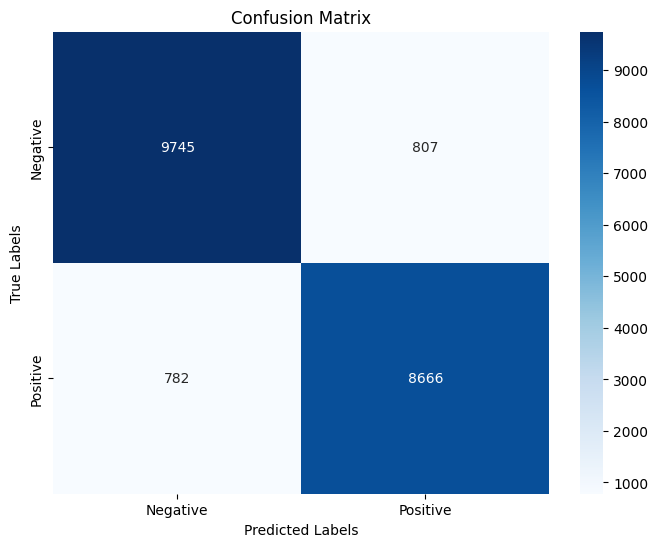

Correct Prediction:
Review: i am extremely happy to be finally out of the monarch apartmentave never beelace that was so disappointing in my entire apartment livinay not have been on the there at the monarch apartment buaoommatill tell you that the two ladies that run that complex are absolutely the most not caring peoplave ever met in my life the monarch apartments especially apartment number is extremelot apartment the entire time of summer for the last years thaave been there with my friend never got any cooler than degrees never weathead the windows open jusrack to help relieve pressure or whether they were closed monarch apartment management came in and replace the blower unit inside the unit which we thought was ended up making it even harder it does not matter how many times we change the filters or complained they did not really care all they said was that has the problem with living up on the third floor more like apartments cooling system is calleind chill ur do not ever live

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define a function to plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define a function to visualize model predictions
def visualize_predictions(true_labels, predictions, reviews):
    correct_indices = np.where(predictions == true_labels)[0]
    incorrect_indices = np.where(predictions != true_labels)[0]

    for idx in correct_indices[:5]:
        print("Correct Prediction:")
        print("Review:", reviews[idx])
        print("Predicted Label:", predictions[idx])
        print("True Label:", true_labels[idx])
        print("---------------------------------")

    for idx in incorrect_indices[:5]:
        print("Incorrect Prediction:")
        print("Review:", reviews[idx])
        print("Predicted Label:", predictions[idx])
        print("True Label:", true_labels[idx])
        print("---------------------------------")

# Plot confusion matrix for testing data
plot_confusion_matrix(true_labels, predictions, ['Negative', 'Positive'])

# Visualize model predictions for a subset of examples
visualize_predictions(true_labels, predictions, x_test)


#### This code calculates the lengths of reviews in the test dataset and plots a histogram to visualize the distribution of review lengths. It helps in understanding the length distribution of reviews and identifying any patterns or outliers in the data.


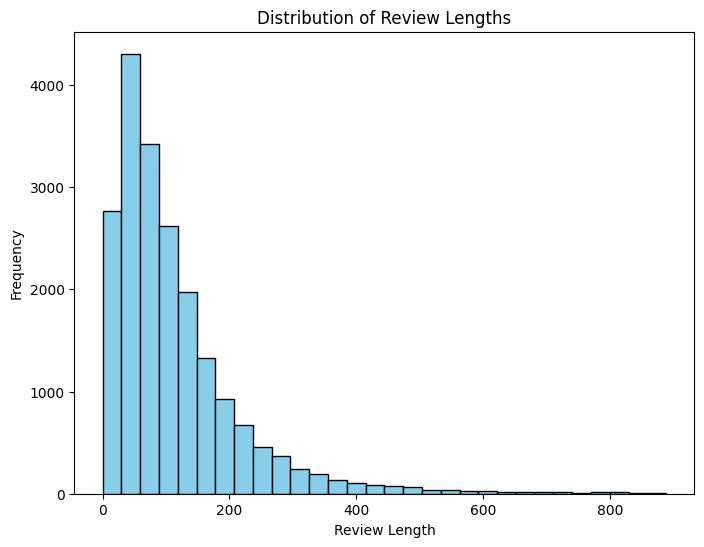

In [16]:
# Analyze the length of reviews
review_lengths = [len(review.split()) for review in x_test]

# Plot histogram of review lengths
plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


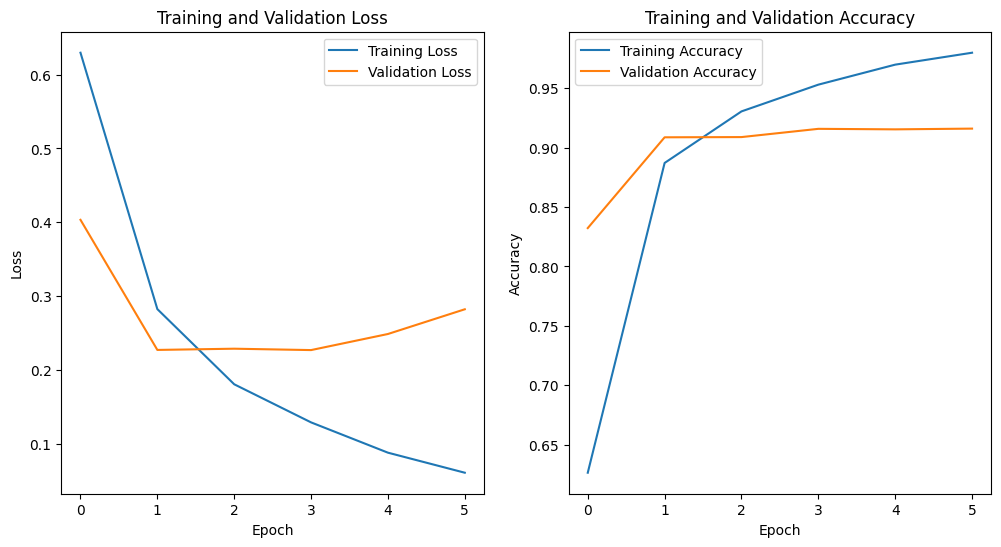

In [20]:
# Learning Curves
def plot_learning_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
# Plot learning curves
plot_learning_curves(train_loss, val_loss, train_accu, val_accu)


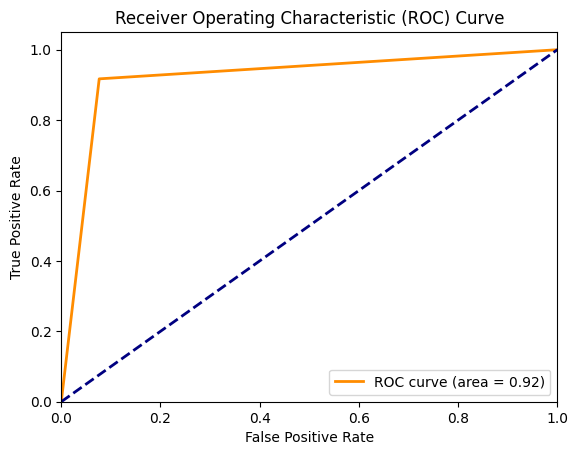

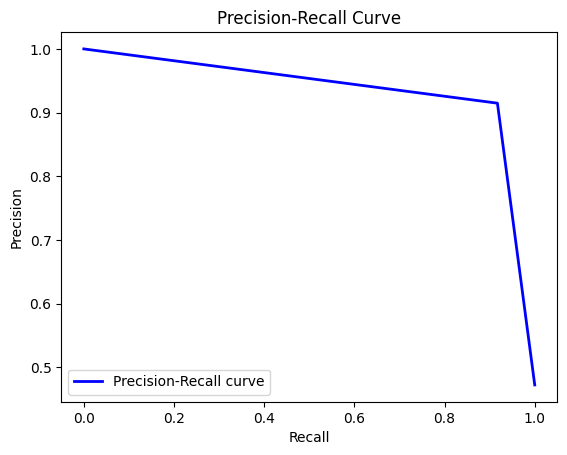

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
# ROC Curve
def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predictions):
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Plot ROC curve
plot_roc_curve(true_labels, predictions)

# Plot Precision-Recall curve
plot_precision_recall_curve(true_labels, predictions)


<ipython-input-25-2400c2069273>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette="viridis")


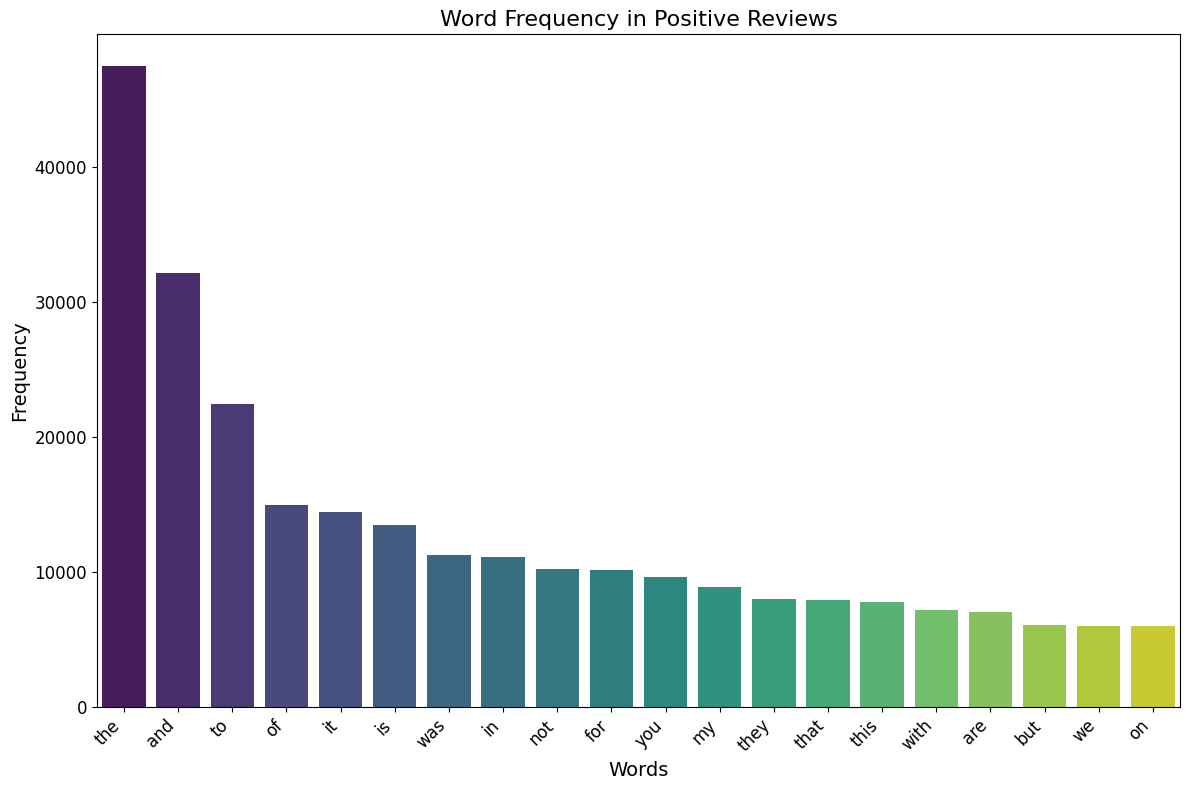

<ipython-input-25-2400c2069273>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette="viridis")


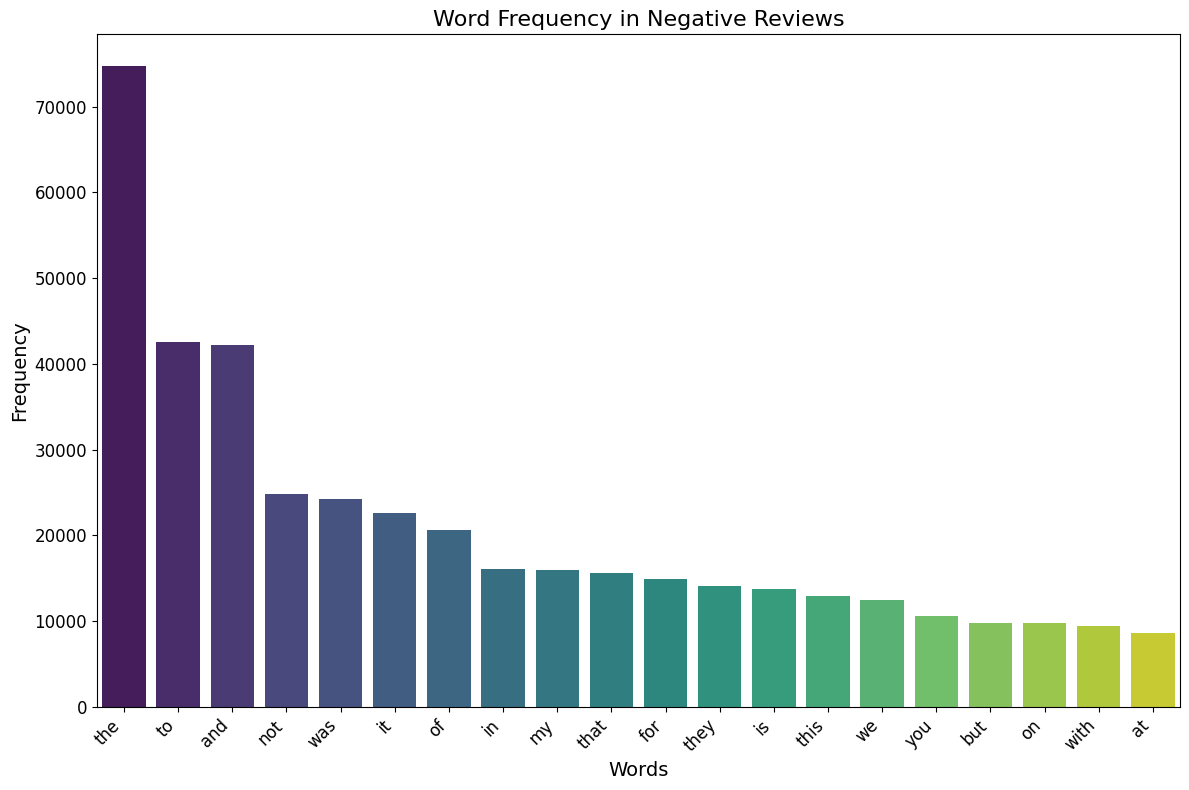

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_word_frequency(word_counts, title, top_n=20):
    # Sort the words by frequency
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    top_words = dict(list(sorted_word_counts.items())[:top_n])

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette="viridis")
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Word Frequency Analysis for positive reviews
positive_word_counts = Counter([word for review in x_test[y_test == 1] for word in review.split()])
plot_word_frequency(positive_word_counts, 'Word Frequency in Positive Reviews')

# Word Frequency Analysis for negative reviews
negative_word_counts = Counter([word for review in x_test[y_test == 0] for word in review.split()])
plot_word_frequency(negative_word_counts, 'Word Frequency in Negative Reviews')


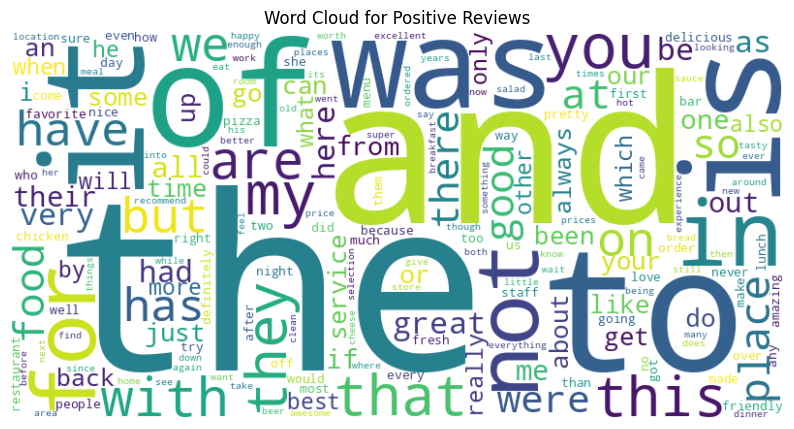

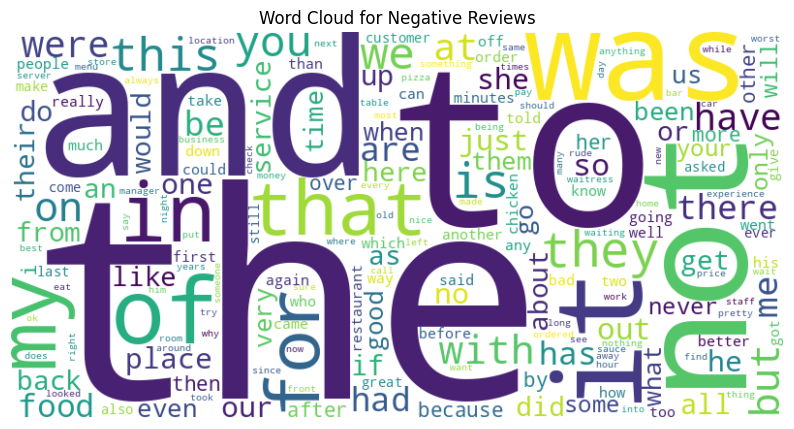

In [26]:
from wordcloud import WordCloud

# Function to generate word cloud from word frequency data
def generate_word_cloud(word_counts, title):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    # Display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for positive reviews
generate_word_cloud(positive_word_counts, 'Word Cloud for Positive Reviews')

# Generate word cloud for negative reviews
generate_word_cloud(negative_word_counts, 'Word Cloud for Negative Reviews')
